In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')

In [3]:
df = pd.read_csv('Kobe.csv')
df.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
# пустые значение есть только у целевой переменной.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

In [5]:
df[['lat','lon','loc_x','loc_y']].corr()

,lat,lon,loc_x,loc_y
lat,1.000000,0.016217,0.016217,-1.000000
lon,0.016217,1.000000,1.000000,-0.016217
loc_x,0.016217,1.000000,1.000000,-0.016217
loc_y,-1.000000,-0.016217,-0.016217,1.000000


In [6]:
# 'lat' и 'lon' полностью коррелируют с 'loc_y' и 'loc_x'. Удаляем lat и lon.
df.drop(['lat', 'lon'], axis=1, inplace=True)

0.0    0.553839
1.0    0.446161
Name: shot_made_flag, dtype: float64

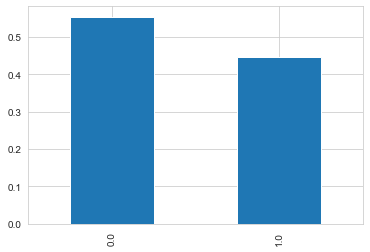

In [7]:
# проверяем целевую переменную.
smf = df.shot_made_flag.value_counts(normalize=True)
smf.plot.bar()
smf.T

In [8]:
# удаляем значения, которые одинаковы для всех строк:
to_del = []
for i in df.columns:
    if len(df[i].value_counts()) == 1:
        to_del.append(i)
        df.drop([i], inplace=True, axis=1)
for elem in to_del:
    print(elem, end = ' ')

team_id team_name 

In [9]:
# Удаляем 'game_id', так как это абстрактное число.
df.drop(['game_id'], axis=1, inplace=True)

In [10]:
# Туда же отправляем 'game_event_id':
df.drop(['game_event_id'], axis=1, inplace=True)

In [11]:
# Поиск информации по играм показал, что матчи с пометкой '@' были сыграны на гостевых аренах.
# Определяем был ли матч сыгран дома или в гостях:
df['homegame'] = df.matchup.apply(lambda x: 1 if x.find('@') == -1 else 0)

In [12]:
df['homegame']=df['homegame'].astype('category')

In [13]:
# в домашних матчах результативность немного выше, чем в гостях:
df.groupby(['homegame'])[['shot_made_flag']].mean()

,shot_made_flag
homegame,
0,0.436421
1,0.456468


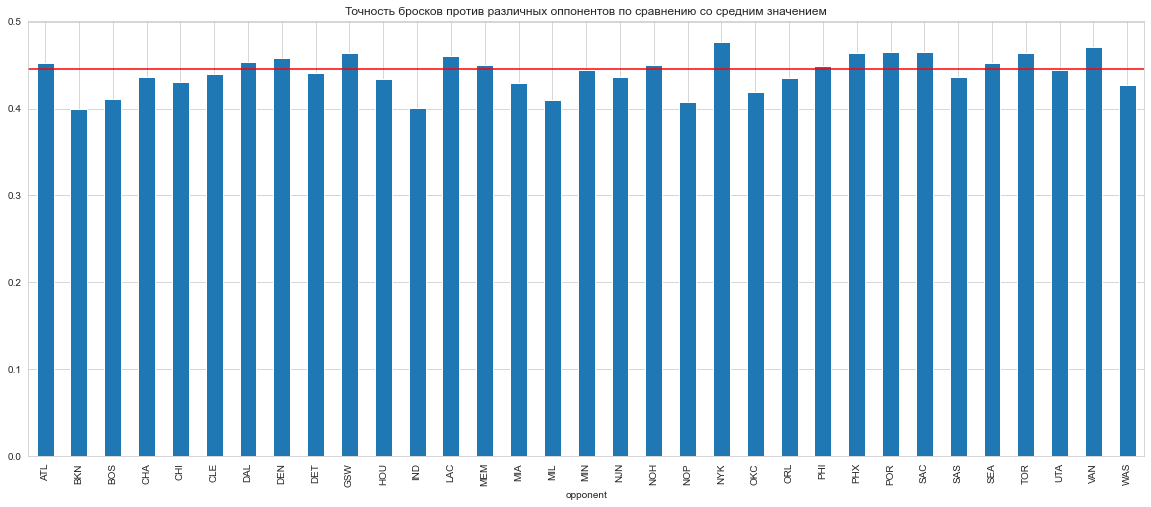

In [14]:
average_success_rate=df.shot_made_flag.mean()
plt.figure(figsize=(20,8))
df.groupby('opponent')['shot_made_flag'].mean().plot(kind='bar')
plt.hlines(average_success_rate, -1, len(df['opponent'].unique()), colors='red')
plt.title('Точность бросков против различных оппонентов по сравнению со средним значением')
plt.show()

In [15]:
# при играх с разными оппонентами, точность немного отличается.
df['opponent']=df['opponent'].astype('category')

In [16]:
# разбиваем дату игры на несколько фич:
df['game_date']=pd.to_datetime(df['game_date'])

df['weekofyear']=df.game_date.apply(lambda x:x.weekofyear)
df['dayofweek']=df.game_date.apply(lambda x:x.dayofweek)
df['year']=df.game_date.apply(lambda x:x.year)
df['month']=df.game_date.apply(lambda x:x.month)

df['weekofyear']=df['weekofyear'].astype('category')
df['dayofweek']=df['dayofweek'].astype('category')
df['year']=df['year'].astype('category')
df['month']=df['month'].astype('category')

In [17]:
# возможно будет иметь значение кол-во дней на отдых после предыдущей игры.
diff = []
dates = list(df['game_date'].unique())
new_date = pd.Timestamp(dates[0])

for i in dates:
    diff.append((i - new_date).days)
    new_date = pd.Timestamp(i)
prev_match = dict(zip(list(df['game_date'].unique()), diff))
df['days_after_previous'] = df['game_date'].map(prev_match)
df['days_after_previous'] = df['days_after_previous'].mask((df['days_after_previous'] > 10) | (df['days_after_previous'] < 0), 10)

In [18]:
# разница несущественная, но можно оставить.
df.groupby(['days_after_previous'])['shot_made_flag'].mean()

days_after_previous
0     0.444444
1     0.444466
2     0.447515
3     0.443891
4     0.448738
5     0.441919
6     0.457077
7     0.438202
8     0.558140
9     0.486111
10    0.422118
Name: shot_made_flag, dtype: float64

In [19]:
df.drop(['game_date'], axis=1, inplace=True)

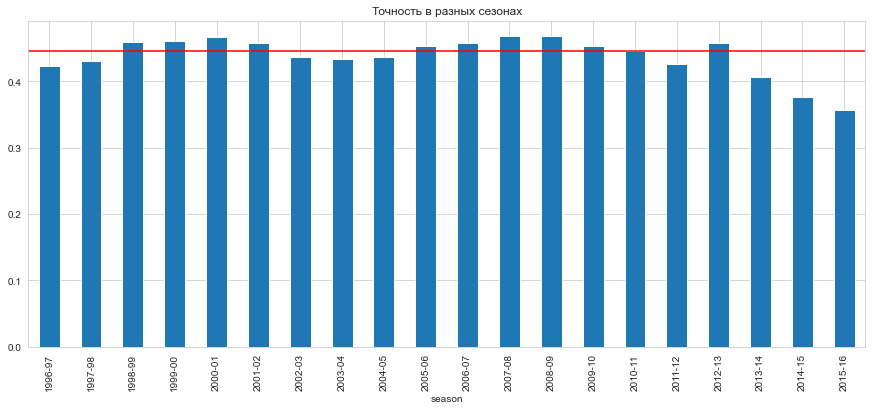

In [20]:
plt.figure(figsize=(15,6))
df.groupby('season')['shot_made_flag'].mean().plot(kind='bar')
plt.hlines(average_success_rate, -1,20, colors='red')
plt.title('Точность в разных сезонах')
plt.show()

In [21]:
df['season']=df.season.astype('category')

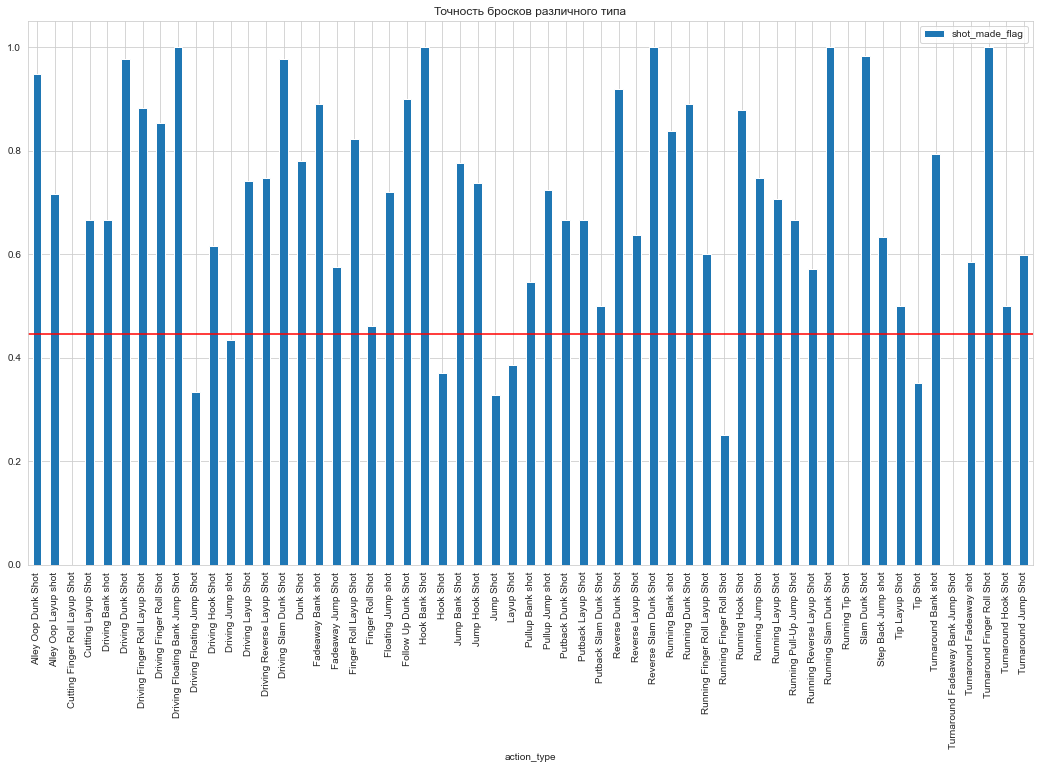

In [22]:
pd.DataFrame(df.groupby(['action_type'])['shot_made_flag'].mean()).plot.bar(figsize=(18,10))
plt.hlines(average_success_rate, -1, len(df['action_type'].unique()), colors='red')
plt.title('Точность бросков различного типа')
plt.show()

In [23]:
df['action_type']=df['action_type'].astype('category')

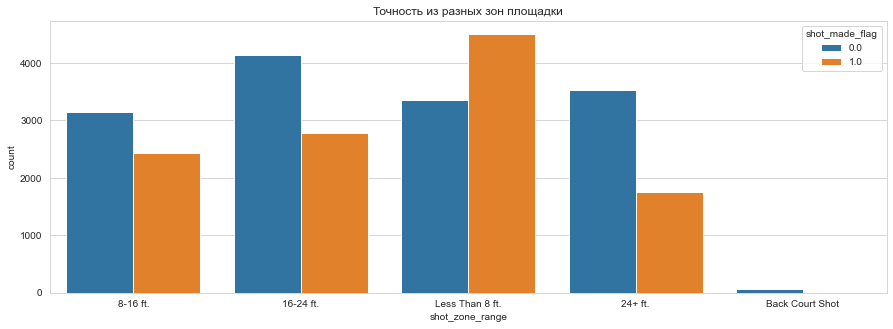

In [24]:
plt.figure(figsize=(15,5))
sns.countplot('shot_zone_range',hue='shot_made_flag',data=df[df.shot_made_flag.notnull()])
plt.title('Точность из разных зон площадки')
plt.show()

In [25]:
df['shot_zone_range']=df['shot_zone_range'].astype('category')

In [26]:
df['shot_zone_area']=df['shot_zone_area'].astype('category')

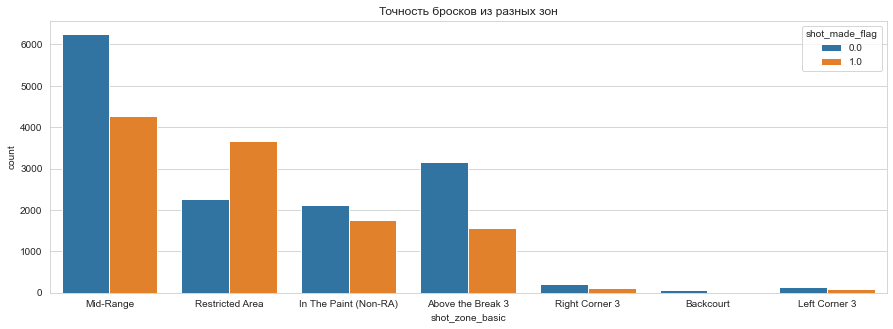

In [27]:
plt.figure(figsize=(15,5))
sns.countplot('shot_zone_basic',hue='shot_made_flag',data=df[df.shot_made_flag.notnull()])
plt.title('Точность бросков из разных зон')
plt.show()

In [28]:
df['shot_zone_basic']=df['shot_zone_basic'].astype('category')

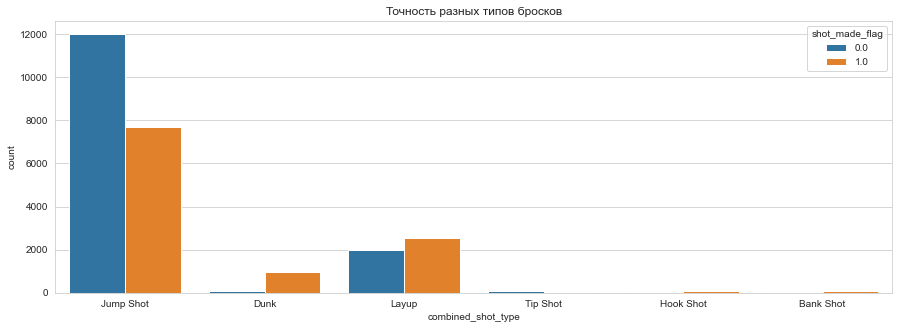

In [29]:
plt.figure(figsize=(15,5))
sns.countplot(x='combined_shot_type',hue='shot_made_flag',data=df[df.shot_made_flag.notnull()])
plt.title('Точность разных типов бросков')
plt.show()

In [30]:
df['combined_shot_type']=df.combined_shot_type.astype('category')

In [31]:
# можно заметить, что в конце каждой игровой четверти на последней минуте
# точность ощутимо снижается ближе к финальной сирене.
for i in range(56,0,-5):
    _ = df[(df['seconds_remaining'] <= i) & (df['minutes_remaining'] == 0)]
    print(round(_.mean()["shot_made_flag"], 3), 'rate,', 'left seconds: ', i)

0.376 rate, left seconds:  56
0.374 rate, left seconds:  51
0.367 rate, left seconds:  46
0.361 rate, left seconds:  41
0.342 rate, left seconds:  36
0.335 rate, left seconds:  31
0.327 rate, left seconds:  26
0.315 rate, left seconds:  21
0.31 rate, left seconds:  16
0.298 rate, left seconds:  11
0.273 rate, left seconds:  6
0.208 rate, left seconds:  1


In [32]:
# добавляем колонку 'последняя минута'
df['last_min'] = df.minutes_remaining.apply(lambda x: 1 if x < 1 else 0)
df['last_min'].astype('category')
df.groupby(['last_min'])['shot_made_flag'].mean()

last_min
0    0.455655
1    0.380542
Name: shot_made_flag, dtype: float64

In [33]:
df['total_secs_remaining'] = df['minutes_remaining']*60 + df['seconds_remaining']

In [34]:
df['last_shot']=df.total_secs_remaining.apply(lambda x: 1 if x < 5 else 0)
df['last_shot']=df['last_shot'].astype('category')

In [35]:
df.groupby(['last_shot'])['shot_made_flag'].mean()

last_shot
0    0.452941
1    0.254276
Name: shot_made_flag, dtype: float64

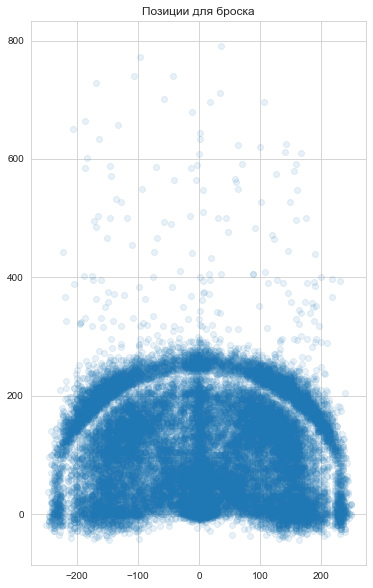

In [36]:
plt.figure(figsize=(6,10))
plt.scatter(df.loc_x, df.loc_y, marker='o', alpha=0.1)
plt.title('Позиции для броска')
plt.show()

In [37]:
df['period']=df['period'].astype('category')
df['playoffs']=df['playoffs'].astype('category')

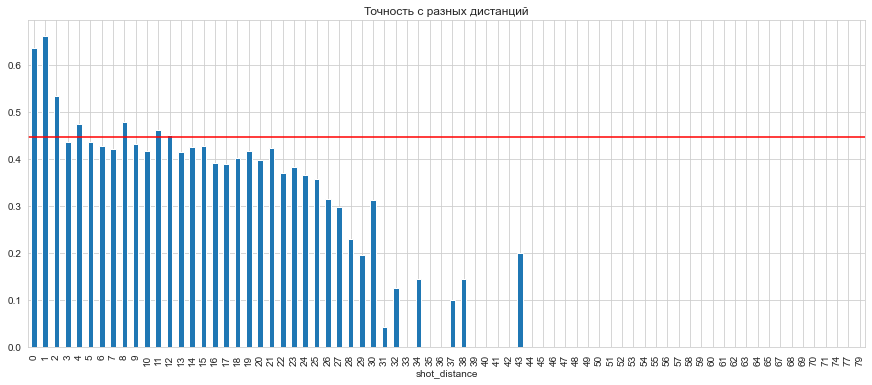

In [38]:
plt.figure(figsize=(15,6))
df.groupby('shot_distance')['shot_made_flag'].mean().plot(kind='bar')
plt.hlines(average_success_rate, -1,80, colors='red',)
plt.title('Точность с разных дистанций')
plt.show()

In [39]:
df2=pd.get_dummies(df.drop(labels='shot_made_flag',axis=1),drop_first=True)
df2

,loc_x,loc_y,minutes_remaining,seconds_remaining,shot_distance,shot_id,days_after_previous,last_min,total_secs_remaining,action_type_Alley Oop Layup shot,...,year_2016,month_2,month_3,month_4,month_5,month_6,month_10,month_11,month_12,last_shot_1
0,167,72,10,27,18,1,0,0,627,0,...,0,0,0,0,0,0,1,0,0,0
1,-157,0,10,22,15,2,0,0,622,0,...,0,0,0,0,0,0,1,0,0,0
2,-101,135,7,45,16,3,0,0,465,0,...,0,0,0,0,0,0,1,0,0,0
3,138,175,6,52,22,4,0,0,412,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,6,19,0,5,0,0,379,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,1,48,6,5,4,30693,3,0,365,0,...,0,0,0,0,0,1,0,0,0,0
30693,0,0,6,5,0,30694,3,0,365,0,...,0,0,0,0,0,1,0,0,0,0
30694,-134,166,3,28,21,30695,3,0,208,0,...,0,0,0,0,0,1,0,0,0,0
30695,31,267,2,10,26,30696,3,0,130,0,...,0,0,0,0,0,1,0,0,0,0


In [40]:
x_train=df2[df.shot_made_flag.notnull()]
y_train=df.shot_made_flag[df.shot_made_flag.notnull()].values
test=df2[df.shot_made_flag.isnull()]

In [41]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(x_train)
x_train_std = sc.transform(x_train)
test_std = sc.transform(test)

In [42]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(x_train_std, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100.0, random_state=1)

In [43]:
lr.score(x_train_std, y_train)

0.6837374012530646

In [44]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(x_train_std, y_train)

Lasso(alpha=0.1)

In [45]:
clf.score(x_train_std, y_train)

0.051947206870786244

In [46]:
from sklearn.linear_model import RidgeClassifier
clf = linear_model.RidgeCV(alphas=[0.1], fit_intercept=True, cv=2).fit(x_train_std, y_train)
clf.score(x_train_std, y_train)

0.1590274683230407

In [47]:
# Не понимаю, почему такие низкие показатели score у Ridge и LAsso?
# "Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или 
# график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, 
# какие зануляются." - не понимаю, что именно требуется в задании.